In [1]:
import numpy as np
import torch
import torch.nn as nn 
from matplotlib import pyplot as plt, ticker as mticker

In [2]:
# create the data
# split the data
SEED = 42
weight = 0.7
bias = 0.3
torch.manual_seed(SEED)

X = torch.arange(0,1, 0.02, dtype=torch.float).unsqueeze(dim=1)
y = weight * X + bias

split_train = int(0.8 * len(X))
X_train, y_train, X_test, y_test = X[:split_train], y[:split_train], X[split_train:], y[split_train:]
len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [3]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [4]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

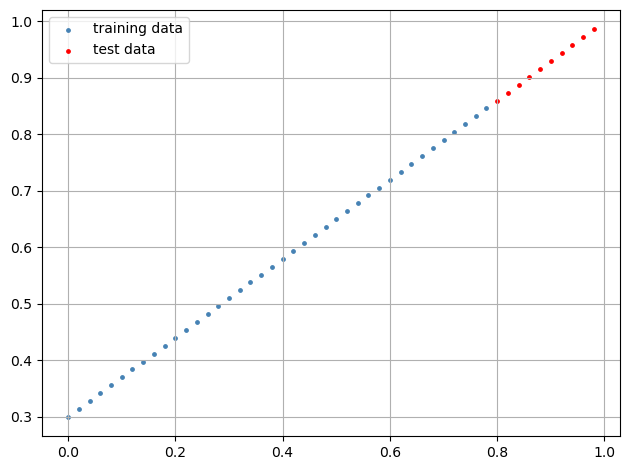

In [5]:
plt.scatter(X_train, y_train, s=6, color="steelblue", label="training data")
plt.scatter(X_test, y_test, s=6, color="red", label="test data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# create the class
class LinearRegressionv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [7]:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [8]:
torch.manual_seed(SEED)
model_linear = LinearRegressionv1()
# model_linear = LinearRegressionModel()
print(model_linear.state_dict())

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


In [9]:
list(model_linear.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
model_linear = model_linear.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [12]:
loss_fun = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_linear.parameters(), lr=0.001)

In [13]:
epochs = 1700
loss_train_values = []
loss_test_values = []
y_pred_test_values = []

for epoch in range(epochs):
    # train
    model_linear.train()
    y_pred_train = model_linear(X_train)
    loss_train = loss_fun(y_pred_train, y_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    # test
    model_linear.eval()
    with torch.inference_mode():
        y_pred_test = (model_linear(X_test))
        loss_test = loss_fun(y_pred_test, y_test)
        loss_test_values.append(loss_test.cpu().detach().numpy())
        loss_train_values.append(loss_train.cpu().detach().numpy())
        y_pred_test_values.append(y_pred_test)

        if epoch % 20 == 0:
            print(f"Epoch {epoch} | MAE Train loss: {loss_train} | MAE Test loss: {loss_test}")

Epoch 0 | MAE Train loss: 0.31288135051727295 | MAE Test loss: 0.4931890666484833
Epoch 20 | MAE Train loss: 0.28983935713768005 | MAE Test loss: 0.4662471413612366
Epoch 40 | MAE Train loss: 0.26679736375808716 | MAE Test loss: 0.43930521607398987
Epoch 60 | MAE Train loss: 0.24375538527965546 | MAE Test loss: 0.41236335039138794
Epoch 80 | MAE Train loss: 0.22071340680122375 | MAE Test loss: 0.38542142510414124
Epoch 100 | MAE Train loss: 0.19767141342163086 | MAE Test loss: 0.35847947001457214
Epoch 120 | MAE Train loss: 0.17462943494319916 | MAE Test loss: 0.3315375745296478
Epoch 140 | MAE Train loss: 0.15158772468566895 | MAE Test loss: 0.304595947265625
Epoch 160 | MAE Train loss: 0.12854604423046112 | MAE Test loss: 0.2776543200016022
Epoch 180 | MAE Train loss: 0.10654275864362717 | MAE Test loss: 0.251315176486969
Epoch 200 | MAE Train loss: 0.08973254263401031 | MAE Test loss: 0.22795839607715607
Epoch 220 | MAE Train loss: 0.07729282230138779 | MAE Test loss: 0.207508251070

In [14]:
with torch.inference_mode():
    y_pred_test_values = model_linear(X_test)

In [15]:
model_linear.state_dict()

OrderedDict([('weights', tensor([0.6984], device='cuda:0')),
             ('bias', tensor([0.3007], device='cuda:0'))])

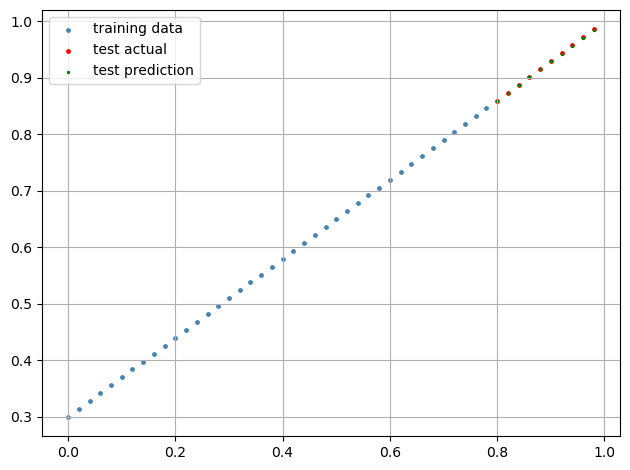

In [16]:
plt.scatter(X_train.cpu(), y_train.cpu(), s=6, color="steelblue", label="training data")
plt.scatter(X_test.cpu(), y_test.cpu(), s=6, color="red", label="test actual")
plt.scatter(X_test.cpu(), y_pred_test_values.cpu().flatten() , s=2, color="green", label="test prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'MAE')

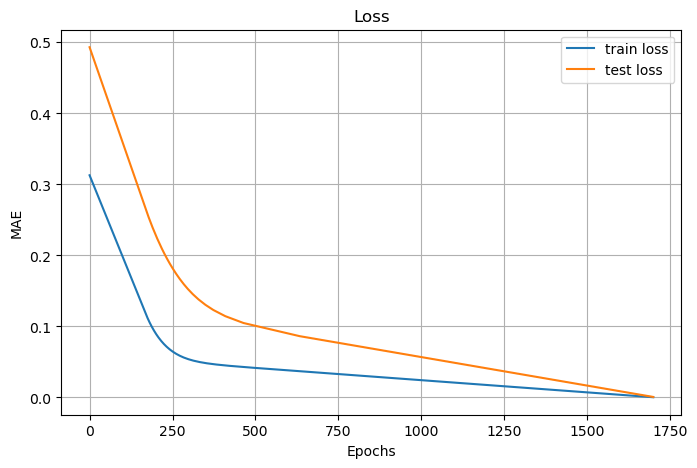

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(loss_train_values, label="train loss")
ax.plot(loss_test_values, label="test loss")
ax.legend()
ax.grid(True)
ax.set_title("Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE")

In [18]:
list(model_linear.parameters())

[Parameter containing:
 tensor([0.6984], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.3007], device='cuda:0', requires_grad=True)]